#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**


In [101]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
from dataclasses import dataclass
import numpy as np
from matplotlib import pyplot as plt

iris = load_iris()

x = iris.data
y = iris.target

In [102]:
def entropy_func(class_count, num_samples):
    """
    Calculates entropy for the given class division from the
    Shannon entropy formula

    H(C)=-(∑ i=1 to k) p(ci)⋅log2(p(ci))

    where:
    k - number of classes
    p(ci) - probability of appearance of class


    """
    if num_samples == 0: return 0

    prob = [count / num_samples for count in class_count if count > 0]
    entropy = -sum(p * math.log2(p) for p in prob)
    return entropy


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return len(self.group_classes)

    def __str__(self):
        return str(self.group_classes)

    def group_entropy(self):
        class_count = Counter(self.group_classes).values()
        num_samples = len(self)
        return entropy_func(class_count, num_samples)


class Node:
    def __init__(self, split_feature=None, split_val=None, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data):
        if self.val is not None:
            return self.val

        if data[self.split_feature] > self.split_val:
            return self.child_node_b.predict(data)
        else:
            return self.child_node_a.predict(data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group):
        """
        Weighted average of groups
        """
        total_samples = len(group_a) + len(group_b)
        group_a_weight = len(group_a) / total_samples
        group_b_weight = len(group_b) / total_samples

        group_a_entropy = group_a.group_entropy()
        group_b_entropy = group_b.group_entropy()

        return group_a_entropy * group_a_weight + group_b_entropy * group_b_weight

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        """
        Diff between parent_group entropy and weighted average of child group entropy
        """

        split_entropy = DecisionTreeClassifier.get_split_entropy(child_group_a, child_group_b)
        return parent_group.group_entropy() - split_entropy

    def get_best_feature_split(self, feature_values, classes):
        """
        Take this feature that maximizes infGain
        """
        max_infgain = float("-inf")
        best_split_val = None

        unique_vals = sorted(set(feature_values))

        for split_val in unique_vals:

            # divide into two groups
            group_a_classes = [classes[i] for i in range(len(classes)) if feature_values[i] <= split_val]
            group_b_classes = [classes[i] for i in range(len(classes)) if feature_values[i] > split_val]

            # create two groups based on division
            child_group_a: Group = Group(group_a_classes)
            child_group_b: Group = Group(group_b_classes)

            parent_group: Group = Group([sum(classes == cls) for cls in np.unique(classes)])

            inf_gain = self.get_information_gain(parent_group, child_group_a, child_group_b)

            if inf_gain > max_infgain:
                max_infgain = inf_gain
                best_split_val = split_val

        return best_split_val, max_infgain


    def get_best_split(self, data, classes):

        max_infgain = float("-inf")
        best_feature = -1
        best_split_val = None

        for feature_idx in range(len(data[0])):

            feature_values = [row[feature_idx] for row in data]
            split_val, inf_gain = self.get_best_feature_split(feature_values, classes)

            if inf_gain > max_infgain:
                max_infgain = inf_gain
                best_feature = feature_idx
                best_split_val = split_val

        return best_feature, best_split_val


    def build_tree(self, data, classes, depth=0):
        if len(set(classes)) == 1:
            return Node(val=classes[0])

        majority_class = Counter(classes).most_common(1)[0][0]

        if depth >= self.max_depth or len(data) <= 1:
            return Node( val=majority_class )

        best_feature, best_split_val = self.get_best_split(data, classes)

        if best_feature == -1 or best_split_val is None:
            return Node( val=majority_class )

        left_indicies = [i for i in range(len(data)) if data[i][best_feature] <= best_split_val]
        right_indicies = [i for i in range(len(data)) if data[i][best_feature] > best_split_val]

        if not left_indicies or not right_indicies:
            return Node( val=majority_class )

        left_data = [data[i] for i in left_indicies]
        right_data = [data[i] for i in right_indicies]

        left_classes = [classes[i] for i in left_indicies]
        right_classes = [classes[i] for i in right_indicies]

        left_tree = self.build_tree(left_data, left_classes, depth + 1)
        right_tree = self.build_tree(right_data, right_classes, depth + 1)

        return Node(best_feature, best_split_val, depth, left_tree, right_tree)

    def print_tree(self, node, depth=0):
        if node.val is not None:
            print(f'{"| " * depth}Leaf: {node.val}')
        else:
            print(f'{"| " * depth}Node: Feature {node.split_feature} <= {node.split_val}')
            self.print_tree(node.child_node_a, depth + 1)
            self.print_tree(node.child_node_b, depth + 1)

    def predict(self, data):
        return self.tree.predict(data)

In [103]:
@dataclass
class AlgorithmRunner:
    accuracy: float = 0.0

    @staticmethod
    def run(max_depth, x_train, x_test, y_train, y_test):
        dc = DecisionTreeClassifier(max_depth)
        dc.tree= dc.build_tree(x_train, y_train)

        correct = 0

        for sample, gt in zip(x_test, y_test):
            prediction = dc.predict(sample)
            print(f'Ground truth: {gt}, Prediction: {prediction}')
            if prediction == gt: correct += 1

        accuracy = correct / len(y_test)
        AlgorithmRunner.accuracy = accuracy

        print(f'Accuracy: {accuracy:.2f}\n')
        dc.print_tree(dc.tree)

    @staticmethod
    def plot_depths(accuracies, depths):
        plt.figure(figsize=(8, 6))
        plt.plot(depths, accuracies, marker='o', linestyle='-', color='b')
        plt.title("Accuracy vs Max Depth of the Decision Tree")
        plt.xlabel("Max Depth")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.show()

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

AlgorithmRunner.run(3, x_train, x_test, y_train, y_test)

Ground truth: 1, Prediction: 2
Ground truth: 2, Prediction: 2
Ground truth: 2, Prediction: 2
Ground truth: 1, Prediction: 1
Ground truth: 0, Prediction: 0
Ground truth: 2, Prediction: 2
Ground truth: 1, Prediction: 1
Ground truth: 0, Prediction: 0
Ground truth: 0, Prediction: 0
Ground truth: 1, Prediction: 1
Ground truth: 2, Prediction: 2
Ground truth: 0, Prediction: 0
Ground truth: 1, Prediction: 1
Ground truth: 2, Prediction: 2
Ground truth: 2, Prediction: 2
Accuracy: 0.93

Node: Feature 2 <= 1.9
| Leaf: 0
| Node: Feature 2 <= 4.8
| | Node: Feature 3 <= 1.6
| | | Leaf: 1
| | | Leaf: 2
| | Node: Feature 3 <= 1.7
| | | Leaf: 2
| | | Leaf: 2


# Test for different depths


Max_depth = 1
Ground truth: 1, Prediction: 1
Ground truth: 2, Prediction: 1
Ground truth: 2, Prediction: 1
Ground truth: 1, Prediction: 1
Ground truth: 0, Prediction: 0
Ground truth: 2, Prediction: 1
Ground truth: 1, Prediction: 1
Ground truth: 0, Prediction: 0
Ground truth: 0, Prediction: 0
Ground truth: 1, Prediction: 1
Ground truth: 2, Prediction: 1
Ground truth: 0, Prediction: 0
Ground truth: 1, Prediction: 1
Ground truth: 2, Prediction: 1
Ground truth: 2, Prediction: 1
Accuracy: 0.60

Node: Feature 2 <= 1.9
| Leaf: 0
| Leaf: 1

Max_depth = 2
Ground truth: 1, Prediction: 2
Ground truth: 2, Prediction: 2
Ground truth: 2, Prediction: 2
Ground truth: 1, Prediction: 1
Ground truth: 0, Prediction: 0
Ground truth: 2, Prediction: 1
Ground truth: 1, Prediction: 1
Ground truth: 0, Prediction: 0
Ground truth: 0, Prediction: 0
Ground truth: 1, Prediction: 1
Ground truth: 2, Prediction: 2
Ground truth: 0, Prediction: 0
Ground truth: 1, Prediction: 1
Ground truth: 2, Prediction: 2
Ground truth

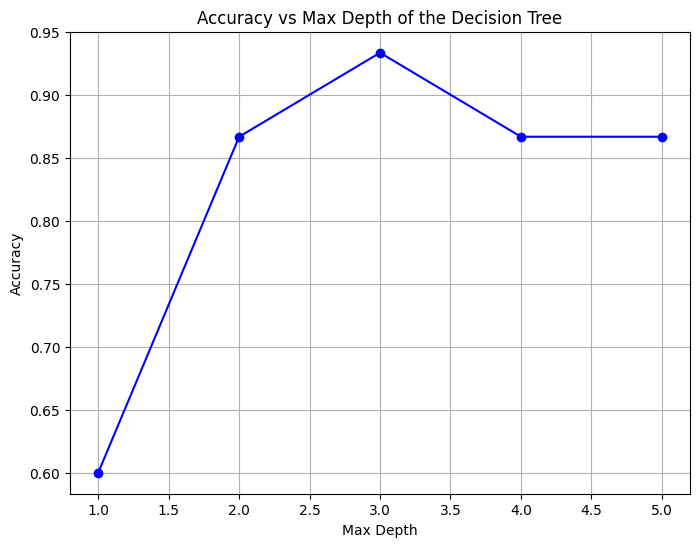

In [ ]:
accuracies = []
depths = []
for depth in range(1, 11):
    print(f"\nMax_depth = {depth}")
    AlgorithmRunner.run(depth, x_train, x_test, y_train, y_test)

    accuracies.append(AlgorithmRunner.accuracy)
    depths.append(depth)

AlgorithmRunner.plot_depths(accuracies, depths)
